In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import make_smoothing_spline

In [469]:
pkl = '../tmp/8035_2024-07-04.pkl'
df0 = pd.read_pickle(pkl)
df0

,Price
2024-07-04 09:00:02,36200.0
2024-07-04 09:00:08,36220.0
2024-07-04 09:00:13,36200.0
2024-07-04 09:00:20,36190.0
2024-07-04 09:00:24,36160.0
...,...
2024-07-04 14:59:34,35900.0
2024-07-04 14:59:40,35910.0
2024-07-04 14:59:46,35910.0
2024-07-04 14:59:56,35890.0


In [470]:
date_str = str(df0.index[0].date())
t_start_1 = pd.to_datetime(date_str + ' 09:00:00')
t_start_2 = pd.to_datetime(date_str + ' 10:00:00')
t_mid = pd.to_datetime(date_str + ' 12:00:00')
t0 = t_start_1.timestamp()
t0

1720083600.0

In [471]:
df1 = df0.loc[df0.index[df0.index < t_mid]]
df1

,Price
2024-07-04 09:00:02,36200.0
2024-07-04 09:00:08,36220.0
2024-07-04 09:00:13,36200.0
2024-07-04 09:00:20,36190.0
2024-07-04 09:00:24,36160.0
...,...
2024-07-04 11:29:20,35910.0
2024-07-04 11:29:41,35910.0
2024-07-04 11:29:50,35910.0
2024-07-04 11:29:52,35920.0


In [472]:
x = np.array([ts.timestamp() - t0 for ts in df1.index])
y = np.array(df1['Price'])

In [473]:
x[len(x) - 1]

np.float64(9000.0)

In [498]:
spl = make_smoothing_spline(x, y, lam=0.001)
xs = np.linspace(x[0], x[len(x) - 1], int((x[len(x) - 1] - x[0]) * 10 + 1))
ys = spl(xs)
xs

array([2.0000e+00, 2.1000e+00, 2.2000e+00, ..., 8.9998e+03, 8.9999e+03,
       9.0000e+03])

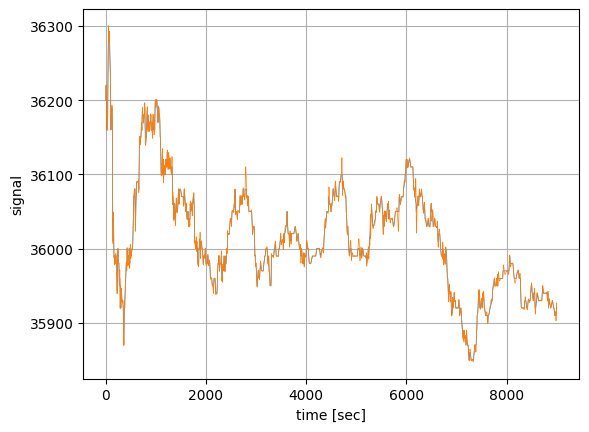

In [499]:
plt.xlabel('time [sec]')
plt.ylabel('signal')
plt.plot(x, y, lw=0.5)
plt.plot(xs, ys, lw=0.5)
plt.grid()
plt.show()

In [500]:
N = len(xs) # サンプル数
dt = 0.1 # サンプリング周期(sec)

In [501]:
# 高速フーリエ変換(FFT)
F = np.fft.fft(ys)

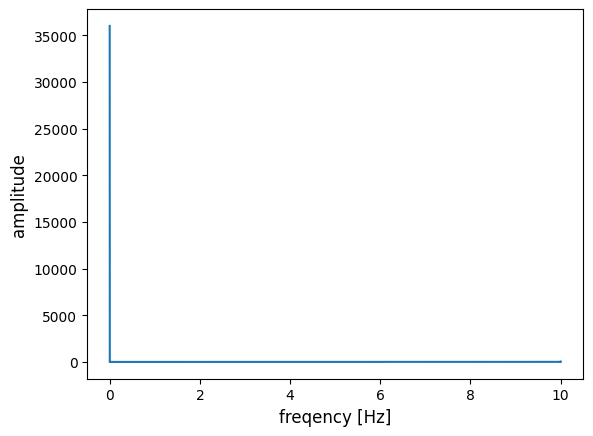

In [502]:
# FFTの複素数結果を絶対値に変換
F_abs = np.abs(F)
# 振幅をもとの信号に揃える
F_abs_amp = F_abs / N * 2 # 交流成分はデータ数で割って2倍
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

# 周波数軸のデータ作成
fq = np.linspace(0, 1.0/dt, N) # 周波数軸　linspace(開始,終了,分割数)

# グラフ表示（FFT解析結果）
plt.xlabel('freqency [Hz]', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F_abs_amp)
#plt.xlim(0, 0.0005)
plt.show()

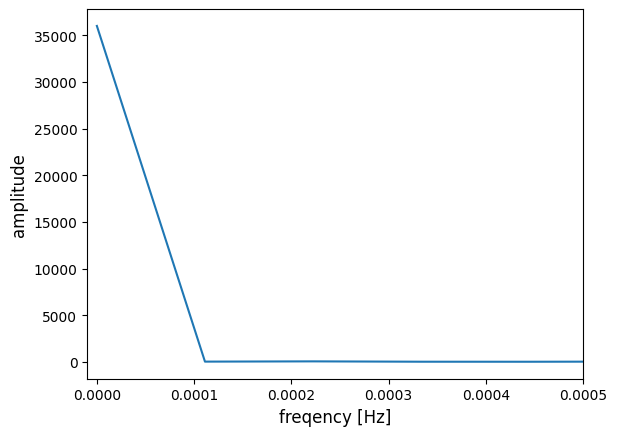

In [503]:
# グラフ表示（FFT解析結果）
plt.xlabel('freqency [Hz]', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F_abs_amp)
plt.xlim(-0.00001, 0.0005)
plt.show()

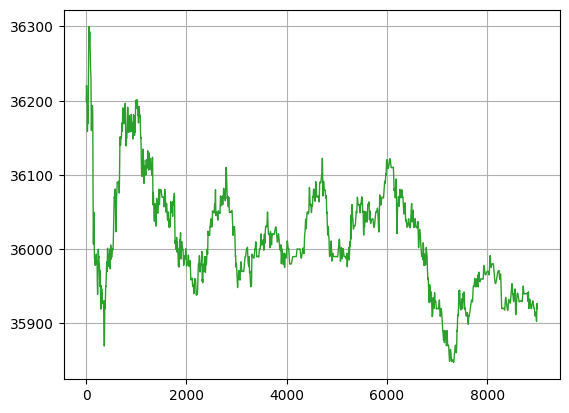

In [504]:
# そのまま普通にIFFTで逆変換した場合
F_ifft = np.fft.ifft(F) # IFFT
F_ifft_real = F_ifft.real # 実数部

plt.plot(xs, F_ifft_real, c='C2', lw=1)
plt.grid()
plt.show()

In [505]:
# 周波数でフィルタリング処理
fc = 0.005 # カットオフ（周波数）
F2 = np.copy(F) # FFT結果コピー
F2[((fc < fq) & (fq < 10 - fc))] = 0 # カットオフを超える周波数のデータをゼロにする（ノイズ除去）

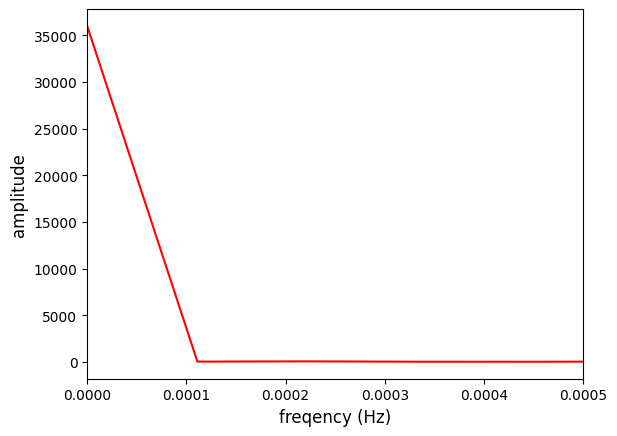

In [506]:
# フィルタリング処理したFFT結果の確認
# FFTの複素数結果を絶対値に変換
F2_abs = np.abs(F2)
# 振幅をもとの信号に揃える
F2_abs_amp = F2_abs / N * 2 # 交流成分はデータ数で割って2倍
F2_abs_amp[0] = F2_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

# グラフ表示（FFT解析結果）
plt.xlabel('freqency (Hz)', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F2_abs_amp, c='r')
plt.xlim(0, 0.0005)
plt.show()

In [507]:
# 周波数でフィルタリング（ノイズ除去）-> IFFT
F2_ifft = np.fft.ifft(F2) # IFFT

In [508]:
#F2_ifft_real = F2_ifft.real * 2 # 実数部の取得、振幅を元スケールに戻す
F2_ifft_real = F2_ifft.real

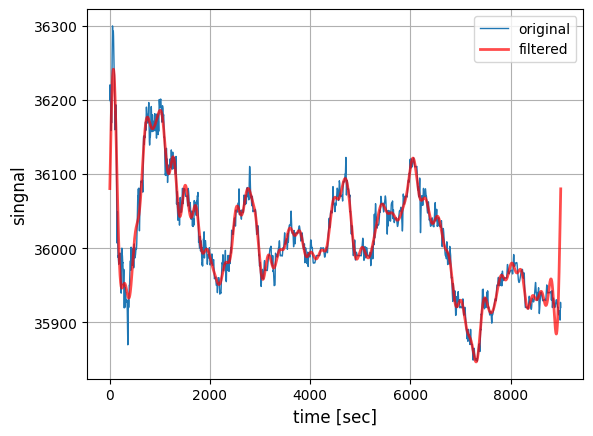

In [509]:
# グラフ表示：オリジナルとフィルタリング（ノイズ除去）
plt.plot(xs, ys, lw=1, c='C0', label='original')
plt.plot(xs, F2_ifft_real, c="red", lw=2, alpha=0.7, label='filtered')
plt.legend(loc='best')
plt.xlabel('time [sec]', fontsize=12)
plt.ylabel('singnal', fontsize=12)
plt.grid()
plt.show()